# Assignment 2
CEE260: Air Transportation  
Paul Sohn  
March 7, 2016  
  
This assignment was completed in Python, so I have written up my explanations in this notebook and provided all calculations below. 

In [1]:
## IMPORTING NECESSARY PACKAGES

%matplotlib inline

from __future__ import division

import numpy as np, pandas as pd, scipy
from scipy.optimize import minimize
from scipy.interpolate import *

import matplotlib
import matplotlib.pyplot as plt

## Question 1
What is stall speed at FL 200 and 300?

First I define a function to return constants, some of which are a function of altitude. These are all given in the assignment, and this function will be useful to later calculations.

In [2]:
def constants(FL):
    
    # Altitude in meters based on FL
    H_meters = FL * 100 * .3048

    # Air temperature in kelvin
    T = 288.16 - 6.5 / 1000 * H_meters

    # Density in kg / m^2
    p = 1.225 * (T/288.16) ** ( (9.80665 / (287 * 6.5 / 1000)) - 1 )

    # Area of wing in m^2
    s = 124.65

    # Weight of airplane in newtons or kg*m / s^2
    w = 65300 * 9.80665
    
    # Speed of sound
    a = np.sqrt(1.4 * 287 * T)
    
    return p, s, w, a

Then I use the formula for stall speed, with constants defined above from the stall speed:

$$
V_{stall} = \sqrt{\frac{2w}{\rho s C_{L,MAX}}} 
$$

In [3]:
# DEFINE A FUNCTION TO RETURN STALL SPEED GIVEN FLIGHT LEVEL

def stall_speed(FL):
    
    # get constants given flight level
    p, s, w, a = constants(FL)

    # maximum lift coefficient, given in problem
    CL_MAX = 1.5
    
    # calculate stall speed in meters / second
    v_m_s = np.sqrt((2*w) / (p*s*CL_MAX))
    
    # in miles per hour (for my own intuition)
    v_mph = v_m_s * 1609.344 / 3600

    # print results
    print "At FL " + str(FL) + ", Stall Speed: " + str(v_m_s) + " m/s, or " + str(v_mph) + " miles per hour"
    return v_m_s

In [4]:
# Calculate stall speed at FL 200 and 300

print stall_speed(200)
print stall_speed(300)

At FL 200, Stall Speed: 102.44987096 m/s, or 45.7991903141 miles per hour
102.44987096
At FL 300, Stall Speed: 122.264330915 m/s, or 54.6570464924 miles per hour
122.264330915


### Results
Stall speed at FL 200 is **102.5 m/s**  
Stall speed at FL 300 is **122.3 m/s**

## Question 2 and 3
Assume the aircraft is cruising at FL 200. Assuming standard day conditions, plot the thrust required, in Newtons, against cruise speed, in m/sec, assuming the aircraft has a mass of 65,300 kg. Assuming that fuel burn is proportional to thrust and independent of speed (i.e. assume that thrust specific fuel consumption is a constant), find the cruise speed that maximizes endurance and the cruise speed that maximizes range. Convert these speeds to knots (nautical miles/hr) and Mach number to get a feel for the magnitudes involved.

First, I created a function to find the thrust required given constants (density, wing area, airplane mass, and free flow speed) using the following formulas:

$$
C_L \text{(Lift Coefficient)} = \frac{2w}{\rho s v^2}
$$

$$
C_D \text{(Drag Coefficient)} = .024 + .041 C_L^2
$$

$$
T_R \text{(Required Thrust)} = \frac{w}{C_L/C_D}
$$

In [5]:
# DEFINE THRUST REQUIRED GIVEN A CERTAIN SPEED, AND OTHER CONSTANTS (DENSITY, WING AREA, WEIGHT)

def thrust_req(p,s,w,v):
    
    # lift and drag coefficients
    CL = (2*w) / (p*s*v**2)
    CD = .024 + 0.041 * (CL**2)    
    
    # THRUST REQUIRED
    TR = w / (CL/CD)
    
    return TR

We can plot thrust vs. velocity, and we should see a "minimum" point and a parabolic shape:

In [6]:
def thrust_plot(FL):
    
    # CREATE A DATAFRAME OF SPEEDS FROM 0 TO 600 M/S
    df = pd.DataFrame(index=[range(1,600)], columns=["v","T_R"])
    df.v = df.index
    
    # GET CONSTANTS
    p, s, w, a = constants(FL)
    
    # CALCULATE THRUST FOR EACH SPEED IN DATAFRAME
    for i in df.index:
        v = df.loc[i,"v"]
        df.loc[i,"T_R"] = thrust_req(p,s,w,v)
    
    # PLOT THRUST V SPEED
    plt.plot(df.v,df.T_R)
    plt.ylim(0, 300000)
    plt.ylabel("Thrust Required")
    plt.xlabel("Velocity (m/s)")
    plt.show()

    return df

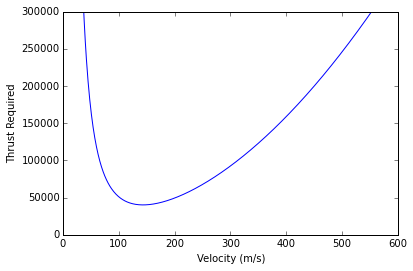

In [7]:
df = thrust_plot(200)

We observe the expected shape fo the curve here. Eyeballing the minimum point gives us a value somewhere in the vicinity of 120 m/s. Next I create a function to find the minimum point on this curve. This is a function of flight level. This is the equivalent of taking the derivative of the thrust curve, setting it equal to 0, and solving for v, as below:

$$ \frac{d}{dv} T_R = 0 $$

$$ \frac{d}{dv} ( w * \frac{a + b C_L^2}{C_L} ) =  0 $$

$$ \frac{d}{dv} ( w * \frac{a + b (\frac{2w}{\rho s v^2})^2}{(\frac{2w}{\rho s v^2})} ) =  0 $$

$$ a \rho s v - \frac{4bw^2}{\rho s v^3} =  0 $$

$$ v = (\frac{4 b w^2}{a \rho^2 s^2})^{\frac{1}{4}} $$

In [8]:
def endurance(FL):
    print "FL " + str(FL)
    
    # GET CONSTANTS
    p, s, w, a = constants(FL)
    
    # DEFINE A HELPER FUNCTION TO CALCULATE REQUIRED THRUST FOR EACH SPEED; IDENTICAL TO PREVIOUS FUNCTION 
    def thrust_min(v):
        CL = (2*w) / (p*s*v**2)
        CD = .024 + 0.041 * (CL**2)
        return w / (CL/CD)
    
    # USE OPTIMIZATION FUNCTION TO MINIMIZE THRUST; RETURN ENDURANCE SPEED
    v_result = minimize(thrust_min,200).x[0]
    
    # CONVERT TO KNOTS AND MACH
    v_knots = v_result * 1.94384
    v_mach = v_result / a
    
    print "endurance speed: " + str(v_result) + " m/s, or " + str(v_knots) + " knots, or Mach " + str(v_mach) 
    return v_result

And now for various flight levels, we can find the minimum point on the curve, which should be the endurance speed:

In [9]:
endurance(200)

FL 200
endurance speed: 143.449893688 m/s, or 278.843641347 knots, or Mach 0.453942256661


143.44989368804733

In [10]:
endurance(360)

FL 360
endurance speed: 191.788586716 m/s, or 372.806326403 knots, or Mach 0.649757495136


191.78858671637792

### Results (part 1):
Endurance speed for FL 200 is **143.4 m/s**, or **278.8** knots, or **Mach 0.45**  
Endurance speed for FL 360 is **191.8 m/s**, or **372.8** knots, or **Mach 0.65**

Next, to find range speed, we have to find the point on the thrust curve that is tangent to the line from the origin. I define a new function that interpolates the slope of the thrust curve between integer values of velocity (I use integer steps for simplicity), and finds the velocity at which the thrust curve has a slope equal to that of the line from the origin to the curve. This is a numerical approximation of the continuous mathematical solution: differentiating thrust with respect to velocity, setting that function equal to the thrust divided by velocity, and solving for v (as below):

$$ \frac{d}{dv} T_R = \frac{T_R}{v} $$

$$ \frac{d}{dv} ( w * \frac{a + b C_L^2}{C_L} ) =  w * \frac{a + b C_L^2}{C_L} * \frac{1}{v}$$

$$ \frac{d}{dv} ( w * \frac{a + b (\frac{2w}{\rho s v^2})^2}{(\frac{2w}{\rho s v^2})} ) =  w * \frac{a + b (\frac{2w}{\rho s v^2})^2}{(\frac{2w}{\rho s v^2})} * \frac{1}{v}$$

$$ a \rho s v - \frac{4bw^2}{\rho s v^3} =  w * \frac{a + b (\frac{2w}{\rho s v^2})^2}{(\frac{2w}{\rho s v^2})} * \frac{1}{v}$$

$$ v = (\frac{12 b w^2}{a \rho^2 s^2})^{\frac{1}{4}} $$

In [11]:
def range_speed(FL):
    
    df = pd.DataFrame(index=[range(1,600)], columns=["v","T_R"])
    df.v = df.index
    
    p, s, w, a = constants(FL)
    
    for i in df.index:
        
        v = df.loc[i,"v"]

        # lift and drag coefficients
        CL = (2*w) / (p*s*v**2)
        CD = .024 + 0.041 * (CL**2)

        # THRUST REQUIRED
        TR = w / (CL/CD)
        
        # assign to df
        df.loc[i,"T_R"] = TR
    
    # GENERATE NUMERIC DERIVATIVES AND CHECK FOR SLOPE CLOSEST TO LINE FROM ORIGIN
    df["slope"] = None
    for i in df.index:
        if i > 1:
            df.loc[i,"slope"] = df.loc[i,"T_R"] - df.loc[i-1,"T_R"]
            
    df["tangent"] = df.T_R / df.v
    
    df["differ"] = abs(df.slope - df.tangent).astype(float)
    
    range_ix = df["differ"].idxmin()
    v_result = df.loc[range_ix,"v"]
    v_knots = v_result * 1.94384
    v_mach = v_result / a
    print "Final difference: " + str(df.loc[range_ix,"differ"])
    
    print "range speed: " + str(v_result) + " m/s, or " + str(v_knots) + " knots, or Mach " + str(v_mach) 
    return df

In [12]:
range200 = range_speed(200)

Final difference: 1.13890344554
range speed: 189 m/s, or 367.38576 knots, or Mach 0.598084002038


In [13]:
range360 = range_speed(360)

Final difference: 0.198717043055
range speed: 253 m/s, or 491.79152 knots, or Mach 0.857134666269


### Results (part 2)
Endurance speed for FL 200 is **189 m/s**, or **367.4** knots, or **Mach 0.60**  
Endurance speed for FL 360 is **253 m/s**, or **491.8** knots, or **Mach 0.86**

## Question 4

Find the cruise Mach speeds that would be chosen at FL 360 for the cost indexes of 10 and 50 kg/min, using the thrust specific fuel consumption equation provided in the appendix. If wave drag were taken into account, how would this affect your results? Refer to Appendix II, which presents a qualitative variation of total drag coefficient with Mach number. Use this figure to estimate an additive, Mach number dependent, correction to the drag coefficient obtained from the drag polar equation in Appendix I. (Hint: estimate how much larger is Cd at a given Mach number due to wave drag. Use the curve in Appendix II to find the proportion by which Cd increases as a function of free flow Mach speed)

### Part 1: Without Wave Drag

The cruise speeds for various cost indexes are determined by minimizing total cost. This can be simplified as such (as demonstrated in class):

$$ Cost = Fuel + Time $$

The "fuel" component can be determined using the formula for thrust-specific fuel consumption (TSFC):

$$ TSFC = 0.891 * (1 + \frac{v}{4600}) \frac{kg}{min * kN} $$

In order to find the mass of fuel used, we can multiply this by time and thrust. This value must be divided by 1000 to be comparable since the formula uses kilonewtons. The "time" component can be determined using the cost index, which is the value of time, in mass of fuel per unit time; to get fuel cost, we can multiply by time. Finally, to control for trip length, we can divide each component by distance. This gives us:

$$ Cost = TSFC * Thrust * \frac{Time}{Length} + CI * \frac{Time}{Length} $$

$$ Cost = TSFC *  \frac{Thrust}{v} + \frac{CI}{v} $$

I specify a function below to calculate minimum cost based on this formula. This does not take wave drag into account. 

In [14]:
def min_cost(CI, FL, min_guess):

    print "FL " + str(FL) + ", CI: " + str(CI)
    
    # Get constants
    p, s, w, a = constants(FL)
    
    # Determine thrust-specific fuel consumption at a certain speed
    def TSFC(v):
        return (0.891 * (1 + v/4600)) / 1000
    
    # Function for total cost, as described in formula above
    def total_cost(v):
        return CI * 1/v + TSFC(v) * thrust_req(p,s,w,v) * 1/v
    
    # Minimize total cost function, return cruise speed
    v_result = minimize(total_cost,min_guess).x[0]
    
    # Convert optimal cruise speed to knots and Mach
    v_knots = v_result * 1.94384
    v_mach = v_result / a
    
    print "Cruise speed: " + str(v_result) + " m/s, or " + str(v_knots) + " knots, or Mach " + str(v_mach) 
    return v_result

In [15]:
# Determine cruise speed for CI of 10, FL 360
min_cost(10,360,10)

FL 360, CI: 10
Cruise speed: 266.827133501 m/s, or 518.669255184 knots, or Mach 0.903979391401


266.82713350051557

In [16]:
# Determine cruise speed for CI of 50, FL 360
min_cost(50,360,10)

FL 360, CI: 50
Cruise speed: 346.328077896 m/s, or 673.206370937 knots, or Mach 1.17331937339


346.32807789559786

### Part 1 Results 
For CI of 10, cruise speed is **Mach 0.90**  
For CI of 50, cruise speed is **Mach 1.17**

### Part 2: With Wave Drag

To account for wave drag, we have to use the qualitative curve given in the assignment to determine the multiplier that should be applied at various Mach speeds to increase the drag coefficient to a more accurate level. Below I create a function to:
* Plot the qualitative curve
* Determine the percentage difference between the previous drag coefficient and what it should be when accounting for wave drag
* Assign a multiplier for the drag coefficient at various speeds

In [17]:
def additive(FL):
    
    p, s, w, a = constants(FL)
    
    # CREATE DATAFRAME WITH OF C_D vs. SPEED WITHOUT WAVE DRAG
    cd = pd.DataFrame(index=range(1,600), columns = ["v","v_mach","cd_nowave"])
    cd.v = cd.index
    cd.v_mach = cd.v / a
    
    # lift and drag coefficients
    CL = (2*w) / (p*s*df.v**2)
    cd.cd_nowave = .024 + 0.041 * (CL**2) 
    
    # GET DATA FROM QUAlITATIVE CURVE 
    qualmach = [0.6875,0.8643,0.8929,0.9464,1.0000,1.05,1.2,1.5,2.0]
    qualcd = [0.03,0.0367,0.048,0.11,0.128,0.128,.095,.0675,.042]
    qual = pd.DataFrame()
    qual["v_mach"] = qualmach
    qual["cd_wave"] = qualcd
    qual["v"] = (qual.v_mach * a).astype(int)
    qual = qual.drop("v_mach",1)
    
    # MERGE DATAFRAMES
    cd = cd.merge(qual,how="left",on="v")
    cd.cd_wave = cd.cd_wave.interpolate(method="linear")
    
    # CALCULATE ADDITIVE
    cd["additive"] = None
    for i in cd.index:
        cd.loc[i,"additive"] = max(0,cd.loc[i,"cd_wave"] - cd.loc[i,"cd_nowave"])
        
    # ADDITIVE AS MULTIPLIER
    cd["finalCD"] = None
    for i in cd.index:
        cd.loc[i,"finalCD"] = max(cd.loc[i,"cd_wave"],cd.loc[i,"cd_nowave"])
        
    cd["multiplier"] = None
    for i in cd.index:
        cd.loc[i,"multiplier"] = cd.loc[i,"finalCD"] / cd.loc[i,"cd_nowave"]
    
    # CREATE DATAFRAME OF MULTIPLIERS FOR LATER REFERENCE
    adjustment = cd[["v","multiplier"]].fillna(1)

    return cd, adjustment

Below, I plot the drag coefficients with and without wave drag, as well as the additive that will be applied. (In practice, a multiplier is used rather than an additive value).

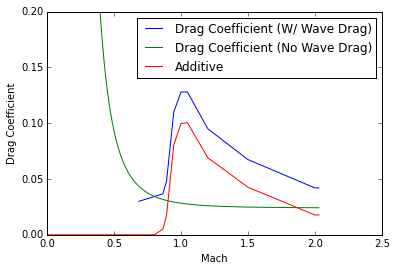

In [18]:
cd, adjustment = additive(360)

# PLOT DIFFERENCE
plt.plot(cd.v_mach,cd.cd_wave)
plt.plot(cd.v_mach,cd.cd_nowave)
plt.plot(cd.v_mach,cd.additive)
plt.legend(["Drag Coefficient (W/ Wave Drag)","Drag Coefficient (No Wave Drag)", "Additive"])
plt.xlabel("Mach")
plt.ylabel("Drag Coefficient")
plt.ylim(0,0.2)
plt.show()

The values of the multiplier at various Mach speeds is displayed below, as inferred from the qualitative curve.

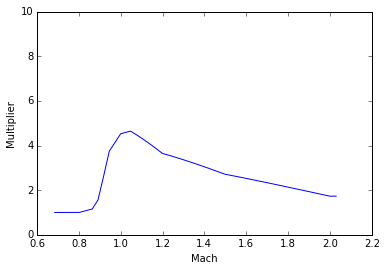

In [19]:
plt.plot(cd.v_mach,cd.multiplier)
plt.xlabel("Mach")
plt.ylabel("Multiplier")
plt.ylim(0,10)
plt.show()

Now that we know how much to adjust the drag coefficient at each speed to take wave drag into account, I create two modified functions below to calculate required thrust (given wave drag), and minimize cost to find a cruise speed. New cruise speeds are reported below.

In [20]:
def thrust_req_withwavedrag2(p,s,w,v):
    # lift and drag coefficients
    CL = (2*w) / (p*s*v**2)

    mult = adjustment.loc[int(v)-1,"multiplier"]
    
    CD = .024 + 0.041 * (CL**2) * mult
    
    # THRUST REQUIRED
    TR = w / (CL/CD)
    
    return TR

In [21]:
def min_cost_wavedrag(CI, FL, min_guess):

    print "FL " + str(FL) + ", CI: " + str(CI)
    
    p, s, w, a = constants(FL)
    
    def TSFC(v):
        return (0.891 * (1 + v/4600)) / 1000
    
    cd, adjustment = additive(FL)
    
    def total_cost(v):

        return CI * 1/v + TSFC(v) * thrust_req_withwavedrag2(p,s,w,v) * 1/v

    v_result = minimize(total_cost,min_guess).x[0]
    v_knots = v_result * 1.94384
    v_mach = v_result / a
    
    print "Cruise speed: " + str(v_result) + " m/s, or " + str(v_knots) + " knots, or Mach " + str(v_mach) 
    return v_result

In [22]:
min_cost_wavedrag(10,360,10)

FL 360, CI: 10
Cruise speed: 236.001261057 m/s, or 458.748691293 knots, or Mach 0.799544909624


236.00126105673101

In [23]:
min_cost_wavedrag(50,360,10)

FL 360, CI: 50
Cruise speed: 255.995422564 m/s, or 497.614142197 knots, or Mach 0.867282810617


255.99542256425551

### Part 2 Results
Now having taken wave drag into account:  
For CI of 10, cruise speed is **Mach 0.80**  
For CI of 50, cruise speed is **Mach 0.87**

## Question 5 and 6

In this problem, take wave drag into account. Suppose the aircraft is going to cruise 3000 km at FL 360 at a constant airspeed associated with a cost index of 50. Assume  the aircraft begins its cruise at a mass of 70,000 kg. Calculate the fuel it would require for the 3000 km cruise in two ways:  
a. Assuming that the mass remains constant over this cruise distance.  
b. Taking into account that the aircraft loses mass as it burns fuel. Comment on the magnitude of the error that results from the first approach.

### Part a
This part is simple given the functions we formulated for the last part. I specify functions below to change the weight of the aircraft, and then determine the total fuel used given thrust-specific fuel consumption (a function of speed) and time. 

In [24]:
def constants_Q5(FL):
    # altitude in meters based on FL
    H_meters = FL * 100 * .3048

    # air temperature in kelvin
    T = 288.16 - 6.5 / 1000 * H_meters

    # density in kg / m^2
    p = 1.225 * (T/288.16) ** ( (9.80665 / (287 * 6.5 / 1000)) - 1 )

    # area of airfoil in m^2
    s = 124.65

    # weight in newtons or kg*m / s^2
    w = 70000 * 9.80665
    
    # speed of sound
    a = np.sqrt(1.4 * 287 * T)
    
    return p, s, w, a

In [25]:
def min_cost_wavedrag_Q5(CI, FL, min_guess):

    print "FL " + str(FL) + ", CI: " + str(CI)
    
    p, s, w, a = constants_Q5(FL)
    
    def TSFC(v):
        return (0.891 * (1 + v/4600)) / 1000
    
    cd, adjustment = additive(FL)
    
    def total_cost(v):

        return CI * 1/v + TSFC(v) * thrust_req_withwavedrag2(p,s,w,v) * 1/v

    v_result = minimize(total_cost,min_guess).x[0]
    v_knots = v_result * 1.94384
    v_mach = v_result / a
    
    v_km_min = v_result * (60/1000)
    tt = 3000 / v_km_min
    
    print "min cost speed: " + str(v_result) + " m/s, or " + str(v_knots) + " knots, or Mach " + str(v_mach) 
    print "time to travel 3000km: " + str(tt) + " min"
    print "fuel consumption per min: " + str((TSFC(v_result) * 1 * thrust_req_withwavedrag2(p,s,w,v_result))/9.8) + " kg"
    print "fuel consumption: " + str((TSFC(v_result) * tt * thrust_req_withwavedrag2(p,s,w,v_result))/9.8) + " kg"
    return v_result

In [26]:
min_cost_wavedrag_Q5(50,360,10)

FL 360, CI: 50
min cost speed: 237.786499023 m/s, or 462.218908262 knots, or Mach 0.805593088869
time to travel 3000km: 210.272661423 min
fuel consumption per min: 4.39397606245 kg
fuel consumption: 923.933040877 kg


237.7864990234375

### Part a results

When not taking reduced weight from used fuel into account, the total fuel consumption for this trip is **923.9 kg**, at a cruise speed of 237.8 m/s. 

### Part b

This part is much trickier. I assume that we use the same cruise speed as for the previous part (237.8 m/s), but this time iterate the thrust-specific fuel consumption over various time intervals to see how fuel consumption changes with reduced weight of the airplane. This is a numerical approximation of integrating the fuel use function that takes reduced weight into account.

In [27]:
# CREATE A DATAFRAME WITH TIME INTERVALS AS INDEX

time = pd.DataFrame(index = range(0,250), columns=['v','distance traveled','weight',"fuel used"])
time.loc[0,"v"] = min_cost_wavedrag_Q5(50,360,10)
time.loc[0,"distance traveled"] = 0
time.loc[0,"weight"] = 70000 * 9.80665

FL 360, CI: 50
min cost speed: 237.786499023 m/s, or 462.218908262 knots, or Mach 0.805593088869
time to travel 3000km: 210.272661423 min
fuel consumption per min: 4.39397606245 kg
fuel consumption: 923.933040877 kg


In [28]:
def fuel_loss_constantspeed(df, CI, FL, v_result):
    
    p, s, w, a = constants_Q5(FL)
    
    def TSFC(v):
        return (0.891 * (1 + v/4600)) / 1000
    
    d = v_result * (60/1000)
    f = (TSFC(v_result) * 1 * thrust_req_withwavedrag2(p,s,w,v_result))/9.8
    
    last = 0
    
    for i in df.index:
        if i > 0:
            if df.loc[i-1,"distance traveled"] >= 3000:
                last = i
                break
            else:
                w = df.loc[i-1,"weight"]
                df.loc[i,"v"] = v_result
                df.loc[i,"distance traveled"] = df.loc[i-1,"distance traveled"] + d
                
                f = (TSFC(v_result) * 1 * thrust_req_withwavedrag2(p,s,w,v_result))/9.8
                df.loc[i,"fuel used"] = f
                df.loc[i,"weight"] = w - f

    mass_loss = df.loc[0,"weight"] - df.loc[last-1,"weight"] 
    mass_loss_second = df.loc[0,"weight"] - df.loc[last-2,"weight"] 
    print "When taking fuel weight into account, fuel used is between " + str(mass_loss_second) + " and " + str(mass_loss)
    
    return df

In [29]:
df_360 = fuel_loss_constantspeed(time,50,360,min_cost_wavedrag_Q5(50,360,10))

FL 360, CI: 50
min cost speed: 237.786499023 m/s, or 462.218908262 knots, or Mach 0.805593088869
time to travel 3000km: 210.272661423 min
fuel consumption per min: 4.39397606245 kg
fuel consumption: 923.933040877 kg
When taking fuel weight into account, fuel used is between 922.330332702 and 926.720438051


In [30]:
df_200 = fuel_loss_constantspeed(time,50,200,min_cost_wavedrag_Q5(50,200,10))

FL 200, CI: 50
min cost speed: 247.815311754 m/s, or 481.7133156 knots, or Mach 0.784203033969
time to travel 3000km: 201.763158403 min
fuel consumption per min: 6.55242522095 kg
fuel consumption: 1322.03800778 kg
When taking fuel weight into account, fuel used is between 1316.72757479 and 1323.27690231


### Part b results:

For FL 360 and a cost index of 50, after taking reduced weight from used fuel into account, the trip uses **922.3 kg of fuel**, which is almost no difference from the calculation that did not take changing weight into account. 

### Question 6 results:

For FL 200, fuel consumption without taking weight change into account is **1322.0 kg**; after taking weight change into account, the fuel consumption is **1316.7 kg**, again almost no difference.  

These results suggest that a simplifying assumption that the weight of the plane does not change with fuel use may be a safe one in terms of estimating fuel required to make a certain trip.

In order to calculate the price difference between flight levels, we need to find jet fuel prices. Airnav.com is currentl reporting "Jet A" fuel prices at about $4/gallon. One gallon of water equals 3.79 kilograms of water, and jet fuel has an approximate specific gravity of .85, so we can approximate one gallon of jet fuel as equivalent to 3.2 kg. 

$$ \frac{$4}{1 gallon} = \frac {$4}{3.2 kg}  = \frac{$1.25}{kg} $$

$$ 1316.7 kg - 922.3 kg = 394.4 \text{ kg fuel saved by flying at FL 360 rather than FL 200} $$

$$ 394.4 kg * \frac{$1.25}{kg} = $493 $$

So flying at FL360 instead of FL200 saves nearly $500 in fuel over the course of the entire flight.

## Question 7

Using the assumptions in 5, calculate the additional fuel (and associated cost) of carrying one more passenger weighing 200 lbs (including luggage).

Finally, to estimate the fuel and money cost of serving one 200lb passenger, I simply use the same function as above, with a starting weight value and add 200 lbs (889.64 Newtons). Then I compare to previous results.


In [31]:
time_onepax = pd.DataFrame(index = range(0,250), columns=['v','distance traveled','weight',"fuel used"])
time_onepax.loc[0,"v"] = min_cost_wavedrag_Q5(50,360,10)
time_onepax.loc[0,"distance traveled"] = 0
time_onepax.loc[0,"weight"] = 70000 * 9.80665 + 889.64

FL 360, CI: 50
min cost speed: 237.786499023 m/s, or 462.218908262 knots, or Mach 0.805593088869
time to travel 3000km: 210.272661423 min
fuel consumption per min: 4.39397606245 kg
fuel consumption: 923.933040877 kg


In [32]:
df_360 = fuel_loss_constantspeed(time_onepax,50,360,min_cost_wavedrag_Q5(50,360,10))

FL 360, CI: 50
min cost speed: 237.786499023 m/s, or 462.218908262 knots, or Mach 0.805593088869
time to travel 3000km: 210.272661423 min
fuel consumption per min: 4.39397606245 kg
fuel consumption: 923.933040877 kg
When taking fuel weight into account, fuel used is between 923.114539112 and 927.508374602


### Results:

With the additional passenger, we have fuel consumption of 923.1 kg. Without the additional passenger, fuel consumption was 922.3. So we can estimate that each additional passenger requires **0.8 kg of fuel**. This is only **$1 in additional fuel** per passenger.